<a href="https://colab.research.google.com/github/Vikram12301/Semantic-Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6TROEJ/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6TROEJ/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

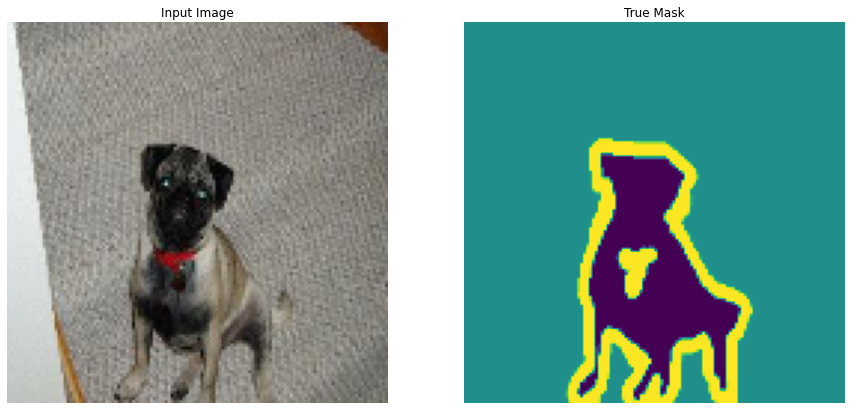

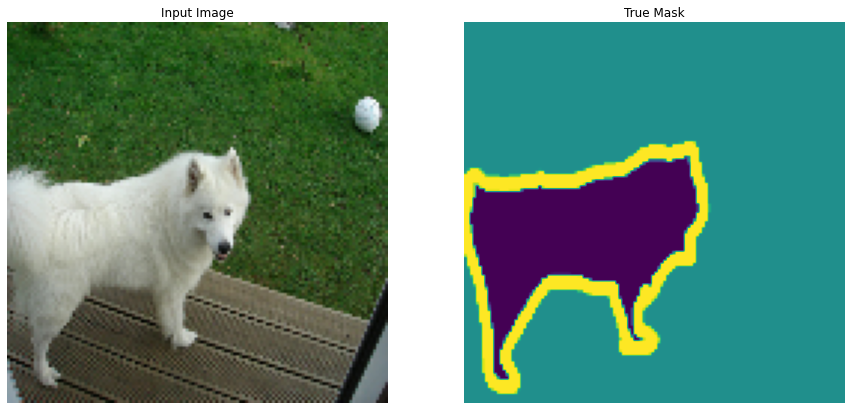

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(conv)        
    else:
        next_layer = conv        
    skip_connection = conv
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16*n_filters, dropout_prob=0.3, max_pooling=False) 
    ublock6 = upsampling_block(cblock5[0], cblock4[1], 8*n_filters ) 
    ublock7 = upsampling_block(ublock6, cblock3[1],  4*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [ ]:
img_height = 128
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))


In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32


In [ ]:
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_history = unet.fit(train_batches, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/5
115/115 [==============================] - 129s 754ms/step - loss: 1.2305 - accuracy: 0.6086
Epoch 2/5
115/115 [==============================] - 82s 713ms/step - loss: 0.6165 - accuracy: 0.7525
Epoch 3/5
115/115 [==============================] - 82s 709ms/step - loss: 0.5006 - accuracy: 0.7966
Epoch 4/5
115/115 [==============================] - 82s 710ms/step - loss: 0.4435 - accuracy: 0.8194
Epoch 5/5
115/115 [==============================] - 82s 710ms/step - loss: 0.3979 - accuracy: 0.8368


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

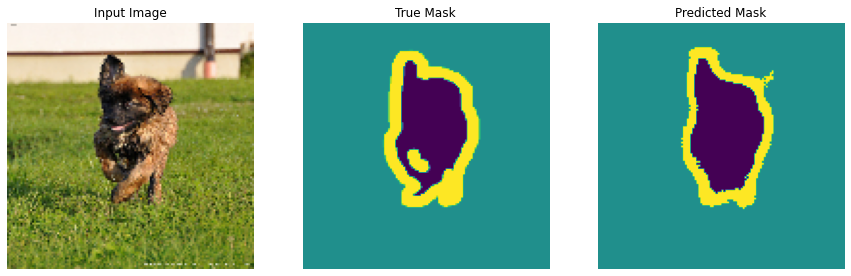

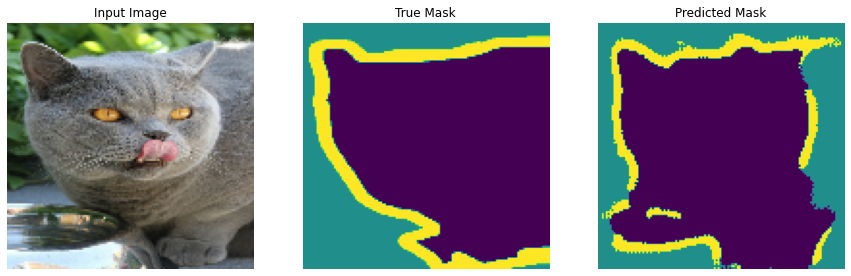

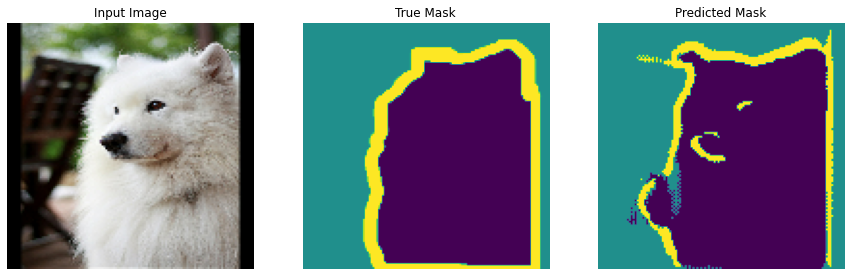

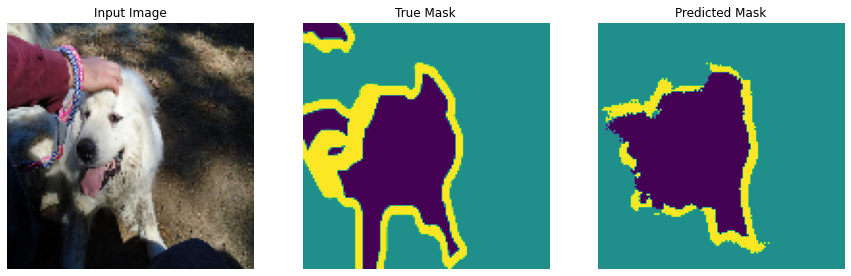

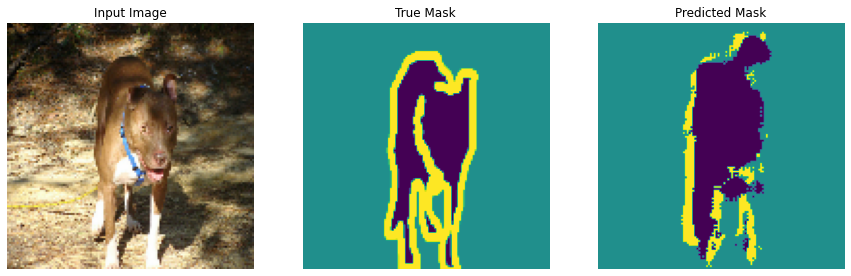

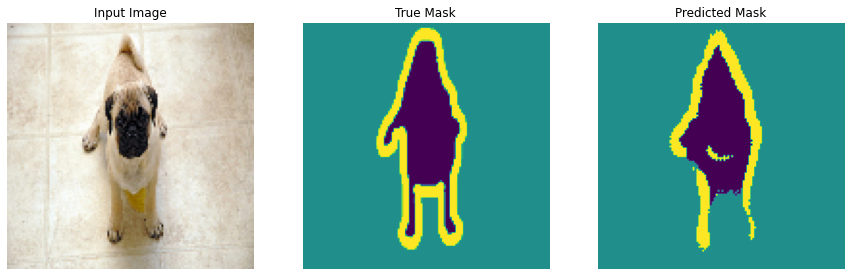

In [ ]:
show_predictions(test_batches, 6)

In [ ]:
EPOCHS = 40
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [ ]:
model_history = unet.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/40
115/115 [==============================] - 88s 767ms/step - loss: 0.3817 - accuracy: 0.8436 - val_loss: 0.3713 - val_accuracy: 0.8475
Epoch 2/40
115/115 [==============================] - 87s 762ms/step - loss: 0.3528 - accuracy: 0.8553 - val_loss: 0.3861 - val_accuracy: 0.8454
Epoch 3/40
115/115 [==============================] - 87s 760ms/step - loss: 0.3280 - accuracy: 0.8643 - val_loss: 0.3462 - val_accuracy: 0.8593
Epoch 4/40
115/115 [==============================] - 87s 759ms/step - loss: 0.3155 - accuracy: 0.8692 - val_loss: 0.3450 - val_accuracy: 0.8601
Epoch 5/40
115/115 [==============================] - 87s 760ms/step - loss: 0.2968 - accuracy: 0.8768 - val_loss: 0.3548 - val_accuracy: 0.8608
Epoch 6/40
115/115 [==============================] - 87s 760ms/step - loss: 0.2900 - accuracy: 0.8795 - val_loss: 0.3418 - val_accuracy: 0.8640
Epoch 7/40
115/115 [==============================] - 87s 760ms/step - loss: 0.2712 - accuracy: 0.8869 - val_loss: 0.3271 - val_ac

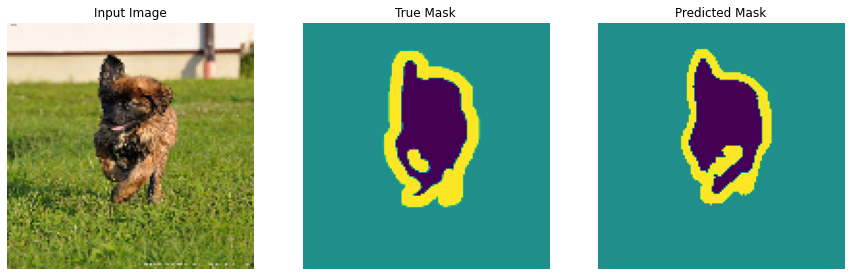

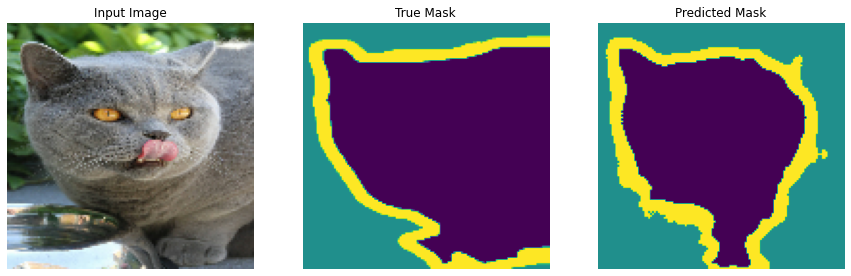

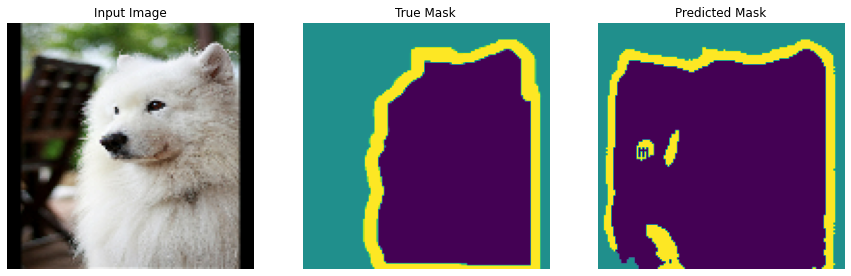

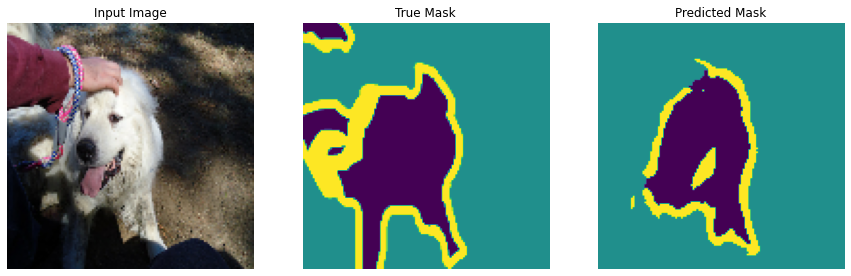

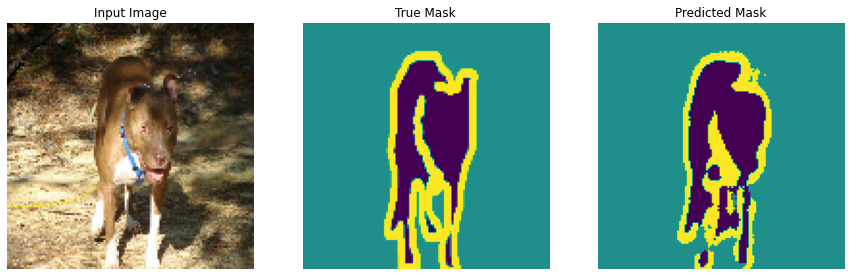

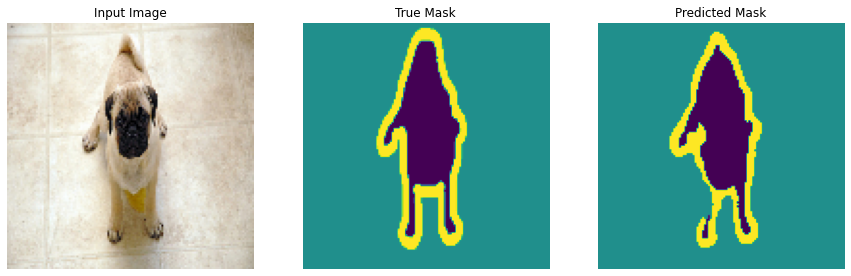

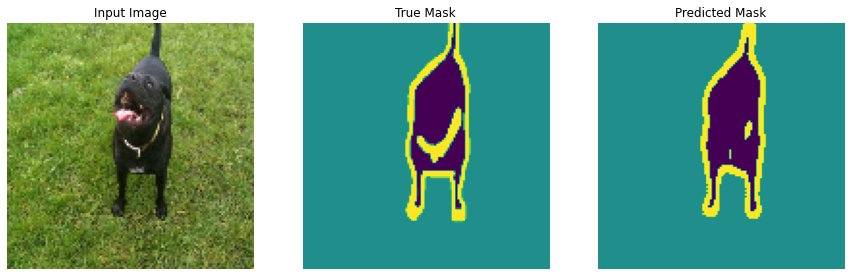

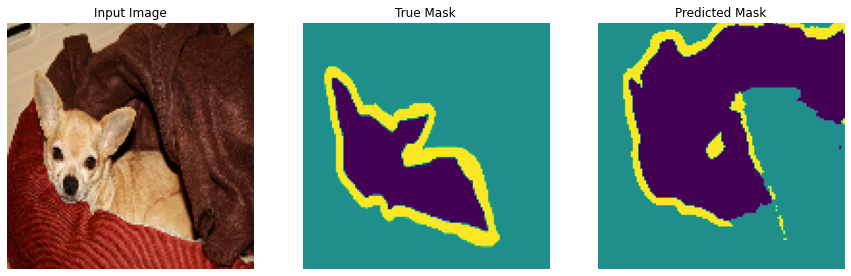

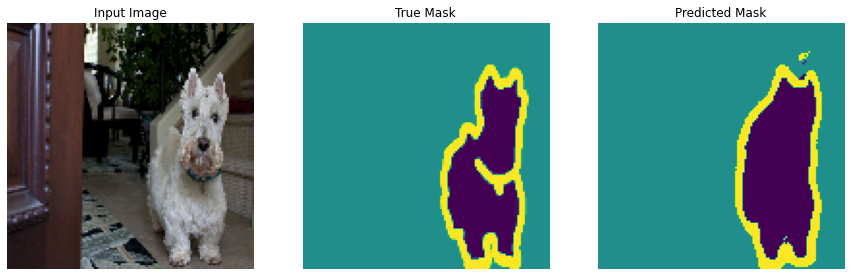

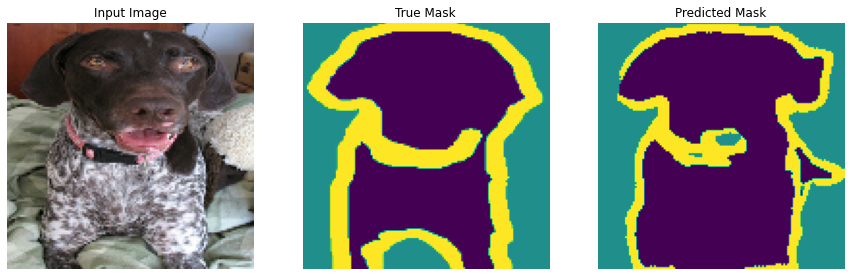

In [ ]:
show_predictions(test_batches, 10)